In [1]:
from gpt.wien_filter import WienFilter
from gpt.lattice import Lattice
from gpt.element import Screen
from gpt.bstatic import Quadrupole

from distgen import Generator
from distgen import PHYSICAL_CONSTANTS
from distgen.writers import write_gpt

qe = PHYSICAL_CONSTANTS.species('electron')['charge'].magnitude
MC2 = PHYSICAL_CONSTANTS.species('electron')['mc2'].magnitude
c = PHYSICAL_CONSTANTS['speed of light in vacuum'].magnitude

from matplotlib import pyplot as plt
import numpy as np
import os


In [2]:
#WF = WienFilter('WF1', 0.0001, 1, selection_energy=6.3e6)

In [3]:
#WF.place()

In [4]:
#WF.gpt_lines()

In [5]:
#WF.plot_floor()

In [6]:
lat = Lattice('SR')
lat.add(WienFilter('WF1', 0.02185, 1.2, selection_energy=6.8e6), ds=0.01)
lat.add(Quadrupole('Q1', 0, 0.26, gap=0.0254), ds=0.015)
lat.add(Screen('scr1'), ds=1.5, ref_element='beg')

<Axes: xlabel='z (m)', ylabel='x (m)'>

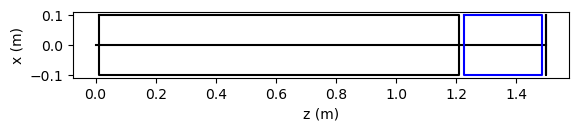

In [7]:
lat.plot_floor()

In [8]:
gpt_lines = lat.write_gpt_lines()

0


In [9]:
with open('gpt.wf.temp.in', 'w') as fid:
    for line in gpt_lines:
        fid.write(line)

In [10]:
from gpt import GPT
from pmd_beamphysics import single_particle

In [11]:
G = GPT('gpt.wf.temp.in', 
        initial_particles = single_particle(pz = lat['WF1'].selection_momentum),
        load_all_gdf_data=True,
        parse_layout=False
       )

In [12]:
G.set_variables({'Ntout': 500, 'ZSTOP':1.75, 'tmax': 50e-9})
G.run()

In [13]:
print(G)


GPT object:
   Original input file: gpt.wf.temp.in
   Template location: /Users/colwyngulliford/GitHub/lume-gpt/examples/elements
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/w8/8n1md1352pzd3nqp0lhc5jy00000gn/T/tmp0mz2jh8q
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 0.09933900833129883 (sec)


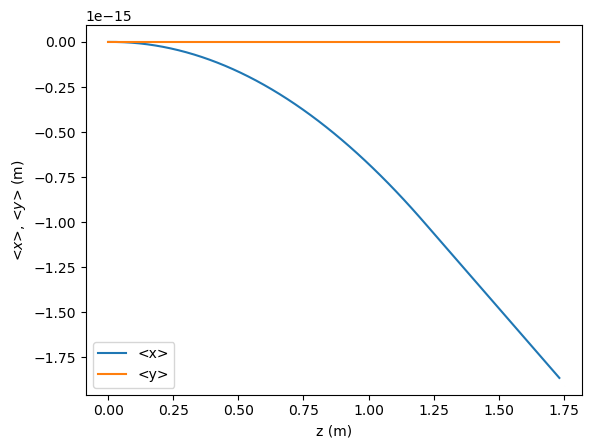

In [14]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_x'))
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_y'))
plt.xlabel('z (m)')
plt.ylabel(r'<$x$>, <$y$> (m)')
plt.legend([r'<x>', r'<y>'])

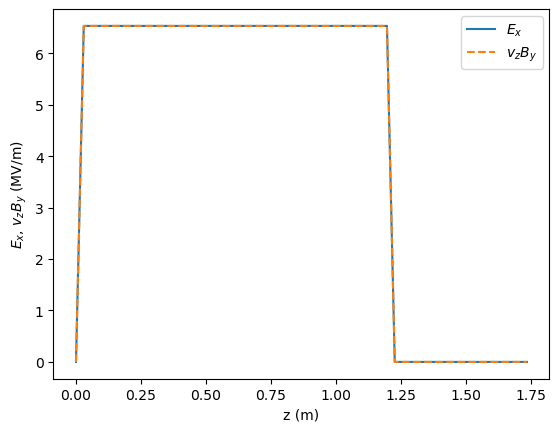

In [15]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_fEx')/1e6)
plt.plot(G.tout_stat('mean_z'), lat['WF1']._v0*G.tout_stat('mean_fBy')/1e6, '--')
plt.xlabel('z (m)') 
plt.ylabel(r'$E_x$, $v_zB_y$ (MV/m)')

plt.legend([r'$E_x$', '$v_zB_y$'])

In [16]:
n_particle = 10_000

pz = lat['WF1'].selection_momentum

betax = 26.8694623292272
alphax = 5.054611659101098
betay = 3.953137534735184
alphay = 0.5054664771205715
emitx = 5.703115949842167E-08 
emity = 5.702851646473836E-08


YAML=f"""
n_particle: {n_particle}
output:
  type: null
random:
  type: hammersley
species: electron
spin_polarization: 0.85
#spin_orientation:
#  theta_x: -85 deg
#  theta_y:  0 deg
#  theta_z:  0 deg
start:
  tstart:
    units: second
    value: 0
  type: time
total_charge: 0.28 pC
#  units: coulomb
#  value: {n_particle*qe}
x_dist: 
  type: gaussian
  sigma_x: 1 mm
y_dist: 
  type: gaussian
  sigma_y: 1 mm
z_dist: 
  type: gaussian
  sigma_z: 150 um
px_dist:
  type: gaussian
  sigma_px: 1 keV/c
py_dist:
  type: gaussian
  sigma_py: 1 keV/c
pz_dist:
  type: gaussian
  avg_pz: {pz} eV/c
  sigma_pz: 20 keV/c
transforms:
  twiss_x:
    type: 'set_twiss x'
    beta: {betax} m
    alpha: {alphax} dimensionless
    emittance: {emitx} m
  twiss_y:
    type: 'set_twiss y'
    beta: {betay} m
    alpha: {alphay} dimensionless
    emittance: {emity} m

#  boost:
#    type: set_avg pz
#    avg_pz: {pz} eV/c
"""

D = Generator(YAML)
B = D.beam()

write_gpt(B, 'gpt_particles.gdf', asci2gdf_bin='$ASCI2GDF_BIN')

In [17]:
print(D)

<disgten.Generator with input: 
n_particle: 10000
output:
  type: null
px_dist:
  sigma_px:
    units: kiloelectron_volt / speed_of_light
    value: 1.0
  type: gaussian
py_dist:
  sigma_py:
    units: kiloelectron_volt / speed_of_light
    value: 1.0
  type: gaussian
pz_dist:
  avg_pz:
    units: electron_volt / speed_of_light
    value: 6780772.822650459
  sigma_pz:
    units: kiloelectron_volt / speed_of_light
    value: 20.0
  type: gaussian
random:
  type: hammersley
species: electron
spin_polarization: 0.85
start:
  tstart:
    units: second
    value: 0.0
  type: time
total_charge:
  units: picocoulomb
  value: 0.28
transforms:
  twiss_x:
    alpha:
      units: dimensionless
      value: 5.054611659101098
    beta:
      units: meter
      value: 26.8694623292272
    emittance:
      units: meter
      value: 5.703115949842167e-08
    type: set_twiss x
  twiss_y:
    alpha:
      units: dimensionless
      value: 0.5054664771205715
    beta:
      units: meter
      value: 3.95

In [18]:
G = GPT('gpt.wf.temp.in', 
        load_fields=True,
        spin_tracking=True,
        parse_layout=False)

In [19]:
G.set_variables({'Ntout': 500, 'ZSTOP':4.0, 'tmax': 50e-9, 'space_charge':1})

{'Ntout': True, 'ZSTOP': True, 'tmax': True, 'space_charge': True}

In [20]:
G.run()

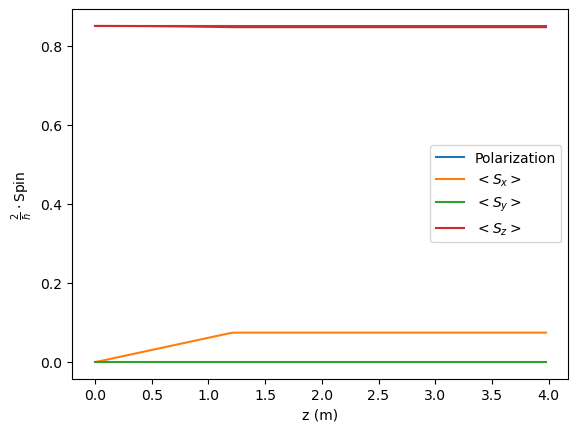

In [21]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('spin_polarization'))
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_spinx'))
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_spiny'))
plt.plot(G.tout_stat('mean_z'), G.tout_stat('mean_spinz'))


plt.xlabel('z (m)')
plt.ylabel(r'$\frac{2}{\hbar}\cdot$Spin ')

plt.legend(['Polarization', '$<S_x>$', '$<S_y>$', '$<S_z>$'])

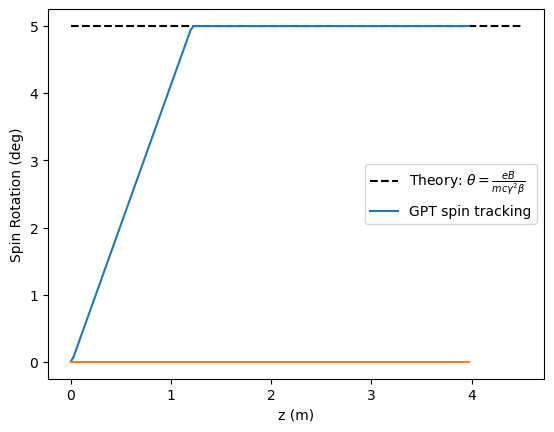

In [22]:
plt.plot([0, 4.5], [5, 5], '--k')
plt.plot(G.tout_stat('mean_z'), np.atan2(G.tout_stat('mean_spinx'), G.tout_stat('mean_spinz'))*180/np.pi)
plt.plot(G.tout_stat('mean_z'), np.atan2(G.tout_stat('mean_spiny'), G.tout_stat('mean_spinz'))*180/np.pi)

#plt.plot(G.screen_stat('mean_z'), G.screen_stat('mean_sz'))
#plt.plot(G.screen_stat('mean_z'), G.screen_stat('mean_sx'))

plt.xlabel('z (m)')
plt.ylabel('Spin Rotation (deg)')
plt.legend([r'Theory: $\theta = \frac{eB}{mc\gamma^2\beta}$', 'GPT spin tracking', ])

In [23]:
def get_rotation(z, B, E):

    gamma = E/MC2

    beta = np.sqrt(1-1/gamma**2)

    return c*B * z / MC2 / gamma**2 / beta

def Bmag(beta, alpha, beta0, alpha0):

    return 0.5 * ( (beta0/beta + beta/beta0) + beta*beta0*(alpha/beta - alpha0/beta0)**2 )

In [24]:
get_rotation(1.2, 0.02185, 6.8e6) * 180/np.pi

np.float64(4.991233918592267)

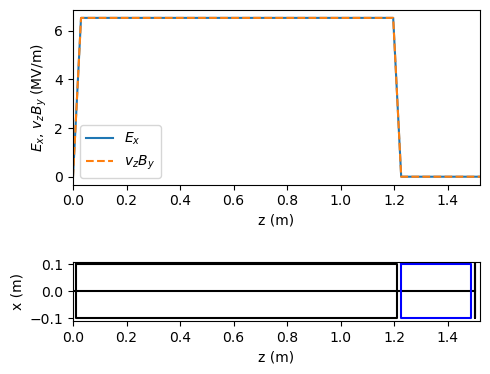

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(5, 4))

axs[0].plot(G.tout_stat('mean_z'), G.tout_stat('mean_fEx')/1e6)
axs[0].plot(G.tout_stat('mean_z'), lat['WF1']._v0*G.tout_stat('mean_fBy')/1e6, '--')
axs[0].set_xlabel('z (m)') 
axs[0].set_ylabel(r'$E_x$, $v_zB_y$ (MV/m)')

axs[0].legend([r'$E_x$', '$v_zB_y$'])




lat.plot_floor(ax=axs[-1])

for ii in range(len(axs)):
    axs[ii].set_xlim([0, 1.52])

plt.tight_layout()

#plt.savefig('6MeV_Wien_Filter_example_fields.pdf')

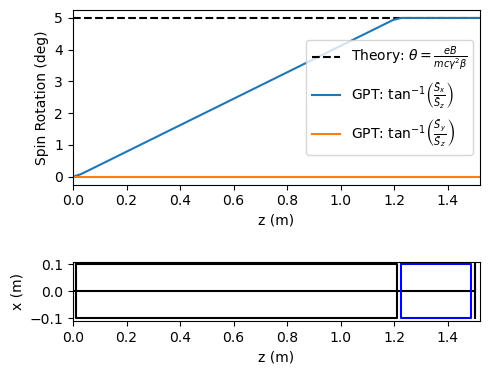

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(5, 4))

axs[0].plot([0, 4.5], [5, 5], '--k')

thetax = np.atan2(G.tout_stat('mean_spinx'), G.tout_stat('mean_spinz'))*180/np.pi
thetay = np.atan2(G.tout_stat('mean_spiny'), G.tout_stat('mean_spinz'))*180/np.pi           

axs[0].plot(G.tout_stat('mean_z'), thetax - thetax[0])
axs[0].plot(G.tout_stat('mean_z'), thetay - thetay[0])

axs[0].set_xlabel('z (m)')
axs[0].set_ylabel('Spin Rotation (deg)')
axs[0].legend([r'Theory: $\theta = \frac{eB}{mc\gamma^2\beta}$', 
               r'GPT: $\text{tan}^{-1}\left(\frac{\bar{S}_x}{\bar{S}_z}\right)$', 
               r'GPT: $\text{tan}^{-1}\left(\frac{\bar{S}_y}{\bar{S}_z}\right)$'])

lat.plot_floor(ax=axs[-1])

for ii in range(len(axs)):
    axs[ii].set_xlim([0, 1.52])

plt.tight_layout()

#plt.savefig('6MeV_Wien_Filter_example_rotation.pdf')

Text(0, 0.5, '$\\sigma_x$, $\\sigma_y$ (mm)')

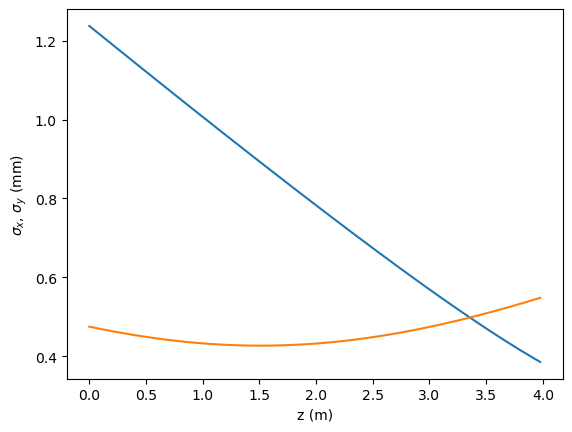

In [27]:
plt.plot(G.tout_stat('mean_z'), G.tout_stat('sigma_x')*1e3)
plt.plot(G.tout_stat('mean_z'), G.tout_stat('sigma_y')*1e3)
plt.xlabel('z (m)')
plt.ylabel(r'$\sigma_x$, $\sigma_y$ (mm)')

In [28]:
#os.remove('gpt_particles.gdf')
#os.remove('gpt.wf.temp.in')

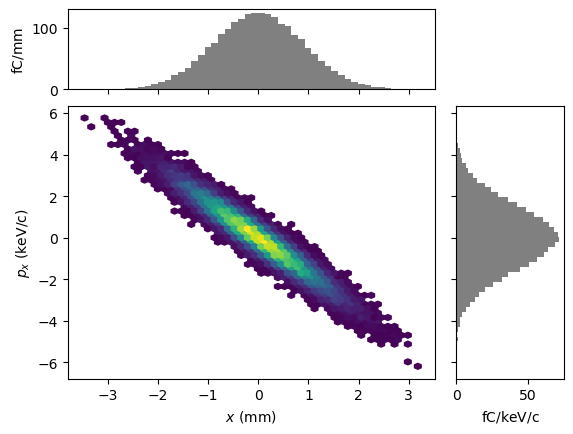

In [29]:
G.screen[-1].plot('x', 'px')

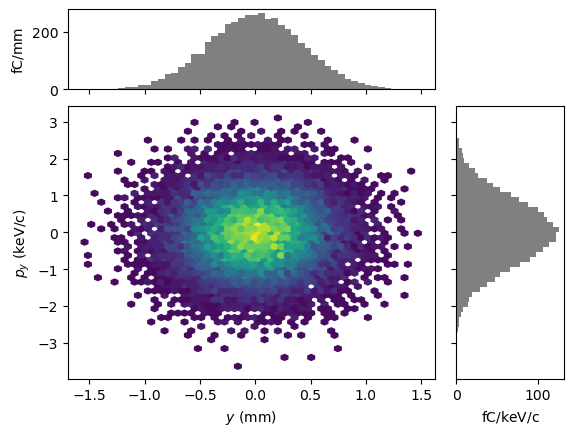

In [30]:
G.screen[-1].plot('y', 'py')

In [31]:
def set_wien_filter(theta, L, E0, G):

    gamma = E0/MC2
    beta = np.sqrt(1 - 1/gamma**2)

    B = theta * MC2*gamma**2 * beta / c / L
    E = c * beta * B

    res = G.set_variables({'WF1_E0':E, 'WF1_B0': B});
    print(B, E, res)

    return G

In [32]:
set_wien_filter(5 * np.pi/180, 1.2, 6.3e6, G)

0.018779031260937048 5611262.155463869 {'WF1_E0': True, 'WF1_B0': True}


In [33]:
#G.screen[-1].twiss()

In [34]:
os.remove('gpt_particles.gdf')

In [35]:
os.remove('gpt.wf.temp.in')